## Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

sns.set_style('darkgrid')

font = {'size': 18}
matplotlib.rc('font', **font)

We read in the pickled dataframe created in the `data_collection` notebook.

In [3]:
df = pd.read_pickle("data/train.pkl")
df.head()

,id,author,title,selftext,time,date,score,num_comments
54442,n97ehm,weremanthing,Refinance my home to free up VA loan or wait?,First let me say thank you for looking at my p...,11:20:52,2021-05-10,1,2
41531,nzf89i,b1ackcat,Thank you for being such a great resource; you...,[removed],01:08:32,2021-06-14,1,2
61126,mxntnt,runnerup,"401k vs 457b, not sure which to max first",My work has both the 401k and 457b plans. They...,12:50:32,2021-04-24,3,7
87222,lg8t6y,Bunburier,"Student Loans, Interest Rate, and Payment Stra...",I'll be attending graduate school soon. Tuitio...,12:44:56,2021-02-09,2,2
34549,obzx08,Mxnchkinz_,What do I put under Gross Income when applying...,I'm applying for a Discover Secured Credit Car...,21:27:28,2021-07-01,0,15


In [4]:
print("The data frame has", len(df.index), "rows and", len(df.columns), "columns")

The data frame has 124941 rows and 8 columns


### Score Distribution

We observe the scores are highly skewed towards 0. 90% of posts have a score less than or equal to 5, and 95% less than 12, and 98% less than 50.

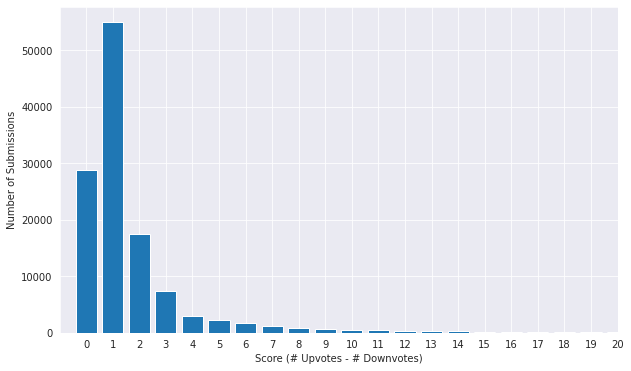

In [5]:
score_freqs = df.score.value_counts().sort_index()
plt.figure(figsize=(10,6))
plt.bar(list(score_freqs.keys()), list(score_freqs))
plt.xlim(-1,20)
plt.xticks([i for i in range(21)])
plt.xlabel('Score (# Upvotes - # Downvotes)')
plt.ylabel('Number of Submissions')
plt.show()

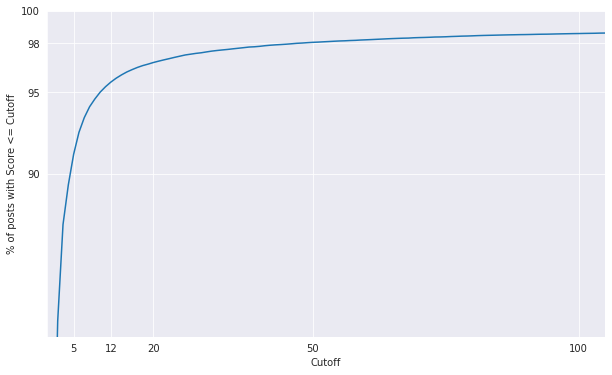

In [6]:
proportions = []
cutoffs = [i for i in range(106)]
for cutoff in cutoffs:
    proportion = sum([100*score_freqs[c] for c in score_freqs.keys() if c <= cutoff]) / sum(score_freqs)
    proportions.append(proportion)

plt.figure(figsize=(10,6))
plt.plot(cutoffs, proportions)
plt.xlabel("Cutoff")
plt.ylabel("% of posts with Score <= Cutoff")
plt.xticks([5, 12, 20, 50, 100])
plt.yticks([90, 95, 98, 100])
plt.xlim(0,105)
plt.ylim(80,100)
plt.show()

### Seasonality of Submissions

Looking at a time series plot of submission counts, we observe more submissions tend to come in during Monday, Tuesday, and Wednesday, and weekends see the fewest submissions.

In [7]:
from datetime import date, timedelta
d0 = date(2020, 10, 1)
days_since_start = [(dt - d0).days for dt in df['date']]
df['days_since_start'] = days_since_start
day_counts = [sum([1 for i in df.days_since_start if i == j]) for j in range(365)]
days = [d0 + timedelta(days=i) for i in range(365)]

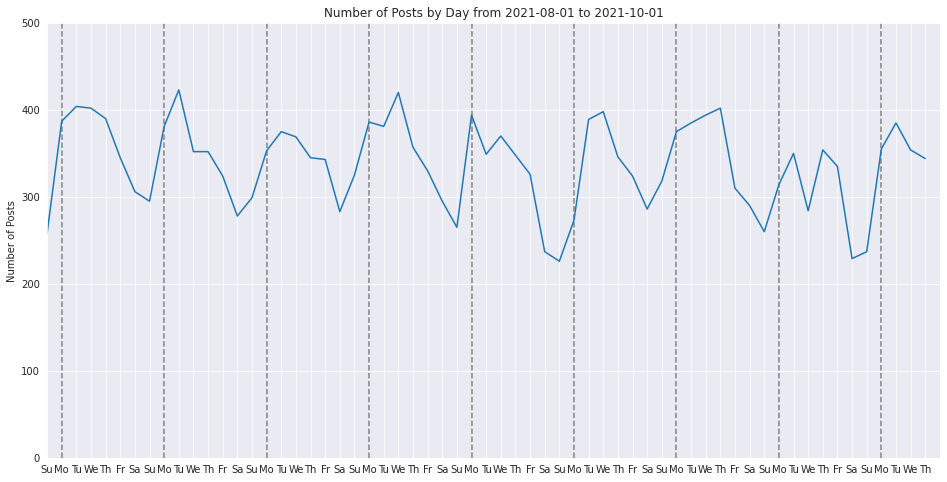

In [8]:
start_day = date(2021, 8, 1)
end_day = date(2021, 10, 1)
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hour = [dt.hour for dt in df['time']]
weekday = [dt.weekday() for dt in df['date']]
df['hour'] = hour
df['weekday'] = weekday
df['weekhour'] = df['hour'] + 24 * df['weekday']

plt.figure(figsize=(16,8))
plt.plot(days, day_counts)
plt.ylabel("Number of Posts")
plt.xlim(start_day, end_day)
plt.xticks([d0 + timedelta(days=i) for i in range((start_day-d0).days, (end_day-d0).days)], 
          labels = [weekdays[(d0 + timedelta(days=i)).weekday()][0:2] for i in range((start_day-d0).days,(end_day-d0).days)], fontsize=10)
plt.vlines([d0 + timedelta(days=i) for i in range((start_day-d0).days,(end_day-d0).days) if (d0 + timedelta(days=i)).weekday() ==0],
           0, 700, linestyles='dashed', color= 'grey')
plt.ylim(0,500)
plt.title("Number of Posts by Day from "+str(start_day)+" to "+ str(end_day))
plt.show()

This trend is cast in sharper relief when we look at the percentage of post submissions for each hour of the week. We can also subset our dataframe to only consider the posts with a score greater than 50, and plot the percentage of such posts for each hour of the week.

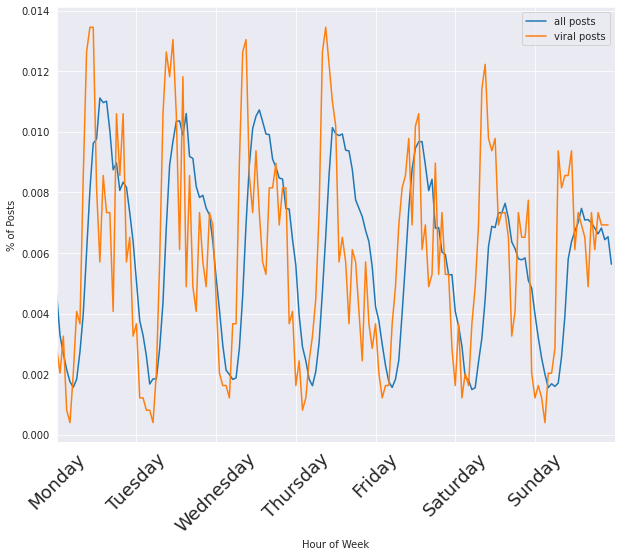

In [9]:
viral = df[df['score'] >= 50]

weekhour_counts = df.groupby('weekhour').count()['id'] / sum(df.groupby('weekhour').count()['id'])
weekhour_counts_viral = viral.groupby('weekhour').count()['id'] / sum(viral.groupby('weekhour').count()['id'])

plt.figure(figsize=(10,8))
plt.plot(range(len(weekhour_counts)), weekhour_counts, label='all posts')
plt.plot(range(len(weekhour_counts_viral)), weekhour_counts_viral, label='viral posts')
plt.xticks([h for h in range(0, 168, 24)], weekdays, fontsize=18, rotation=45)
plt.xlabel("Hour of Week")
plt.ylabel("% of Posts")
plt.xlim(0,168)
plt.legend()
plt.show()

The above plot also reveals seasonality within a given day. In particular, the early hours of the morning see the fewest posts. Then, the number of posts shoots up over the morning and reaches a peak in the early afternoon, and then tapers off gradually throughout the evening. 

We observe the daily seasonality of the subset of viral posts is a little different than the for all posts. In particular, posting in the morning (from 6 am to 10 am) seems to maximize the chances of going viral.

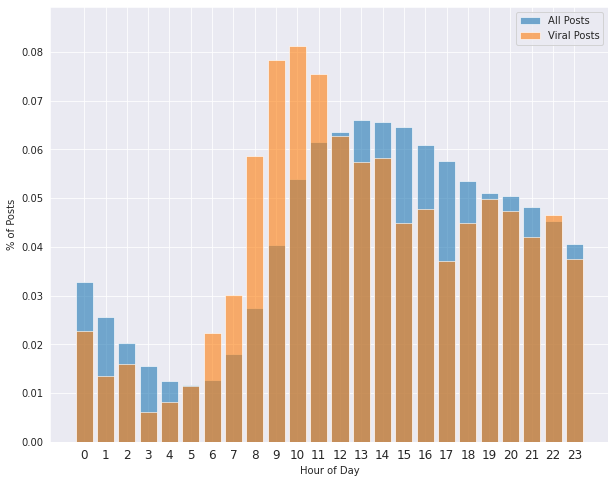

In [10]:
hourly_counts = df.groupby('hour').count()['id'] / sum(df.groupby('hour').count()['id'])
hourly_counts_viral = viral.groupby('hour').count()['id'] / sum(viral.groupby('hour').count()['id'])
plt.figure(figsize=(10,8))
plt.bar(range(len(hourly_counts)), hourly_counts, label='All Posts', alpha = 0.6)
plt.bar(range(len(hourly_counts_viral)), hourly_counts_viral, label='Viral Posts', alpha = 0.6)
plt.xticks([h for h in range(24)], [str(h) for h in range(24)], fontsize=12)
plt.xlabel("Hour of Day")
plt.ylabel("% of Posts")
plt.ylim(0, 1.1*max(hourly_counts_viral))
plt.legend()
plt.show()

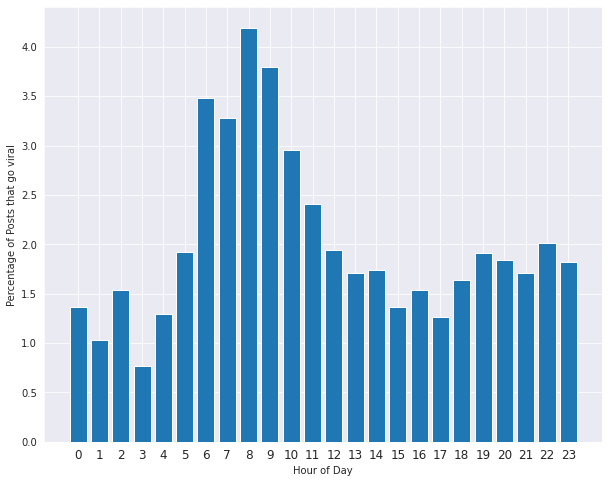

In [11]:
plt.figure(figsize=(10,8))
plt.bar(range(len(hourly_counts)), 100*viral.groupby('hour').count()['id'] / df.groupby('hour').count()['id'])
plt.xticks([h for h in range(24)], [str(h) for h in range(24)], fontsize=12)
plt.xlabel("Hour of Day")
plt.ylabel("Percentage of Posts that go viral")
plt.show()